In [ ]:
import numpy as np
import scipy
from scipy.optimize.elementwise import find_root
import matplotlib.pyplot as plt

# Likelihood-ratio test

Comparison of two bin containing $N_1$ and $N_2$ events. The number of events in each bin is poissonian distributed.

The test statistic for the null hypothesis $\alpha = \dfrac{N_1}{N_2} = \alpha_0$ is:
$$\lambda_\text{LR} = 2 N_2 \left[\alpha\ln\left(\dfrac{\alpha}{\alpha_0}\right) - \left(1 + \alpha\right) \ln\left(\dfrac{1 + \alpha}{1 + \alpha_0}\right)\right]$$
with $\alpha = \dfrac{N_1}{N_2}$.

$\lambda_\text{LR}$ is asymptotically $\chi^2_1$ distributed.

In [2]:
def lambda_LR(alpha_0, alpha, N_2):
    """
    Summary
    -------
    Returns the test statistic for the **likelihood-ratio test** between the number of events in two bins.

    The test statistic is **asymptotically chi-squared** distributed with one degree of freedom for the null hypothesis alpha = alpha_0.
    
    Parameters
    ----------
    alpha_0 : float
        The value against which the null hypothesis is tested.
    alpha : float
        The realized value of the ratio between the number of events in the two bins: N_1 / N_2.
    N_2 : int
        The number of events in the second bin.
        
    Returns
    -------
    float
        The value of the test statistic.

    References
    ----------
    - [1] https://en.wikipedia.org/wiki/Likelihood-ratio_test#
    """
    return 2 * N_2 * (alpha * np.log(alpha / alpha_0) - (1 + alpha) * np.log((1 + alpha) / (1 + alpha_0)))

## Parameters

Initialize $N_1$ and $\alpha = \dfrac{N_1}{N_2}$. Then $N_2 = \dfrac{N_1}{\alpha}$.

Merger rate ratio is given by $\dfrac{R_1}{R_2} = \dfrac{N_1}{N_2} \dfrac{\dfrac{1}{\left\langle VT \right\rangle_1}}{\dfrac{1}{\left\langle VT \right\rangle_2}} = A = \alpha a$, where $a = \dfrac{\dfrac{1}{\left\langle VT \right\rangle_1}}{\dfrac{1}{\left\langle VT \right\rangle_2}}$. Initialize a value of $a$ and compute $A$ consequently.

Define a confidence level $\text{c.l.}$ (e.g. $\text{c.l.} = 0.05 \Longrightarrow 95\%$ confidence level).

In [3]:
N_1 = 80
alpha = 1.3
N_2 = int(N_1 / alpha)

a = 1.1
A = alpha * a

cl = 0.05

## Test $A$ vs. $A_0$

### Using the likelihood-ratio test

I want to test wheter $A = \dfrac{R_1}{R_2} = A_0$, where $A_0$ is fixed (e.g. $1, 2, 3, ...$). Since $A = \alpha a$, I can test whether $\dfrac{N_1}{N_2} = \alpha = \alpha_0 = \dfrac{A_0}{a}$

For my realized value of $A = \dfrac{R_1}{R_2}$, I want to compute the test statistic $\lambda_\text{LR}$ for different value of $A_0$ and the plot $\lambda_{LR}$ vs. $A_0$. Moreover, for each value of $\lambda_\text{LR}$, I compute the associated $\text{p-value}$ using the fact that the test statistic is asymptotically $\chi^2_1$ distributed.

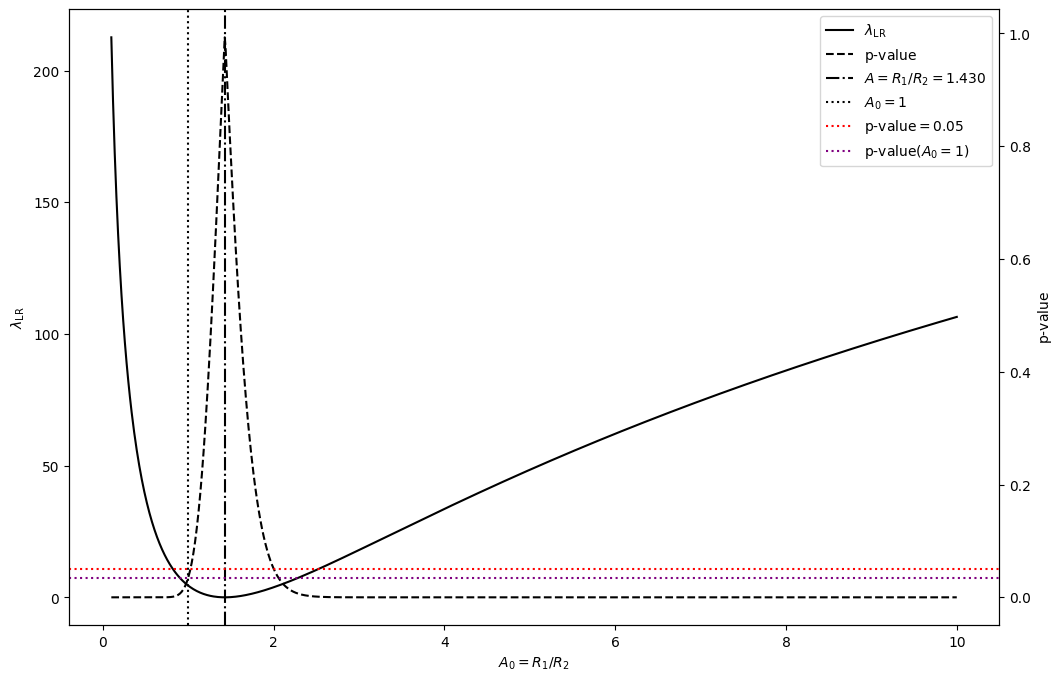

In [4]:
# Define a grid of values for A_0
A_0 = np.linspace(0.1, 10, 1000)

# Compute the test statistic using the the lambda_LR function. Set alpha_0 = A_0 / a as discussed above.
# Compute the associated p-value using the chi_squared distribution implementation in scipy.
# The "sf" function is called the "survival function" and is defined as sf(x) = 1 - cdf(x), where cdf is the cumulative distribution function.
# The second argument of the "sf" function is the number of degrees of freedom, which is 1 in our case.
p_value_LR = scipy.stats.chi2.sf(lambda_LR(A_0 / a, alpha, N_2), 1)

# PLOT
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

twin_ax = ax.twinx()

twin_ax.set_ylabel(r'$\text{p-value}$')

ax.set_xlabel(r'$A_0 = R_1 / R_2$')
ax.set_ylabel(r'$\lambda_\text{LR}$')

lines = []

# Test statistic
lines.append(ax.plot(A_0, lambda_LR (A_0 / a, alpha, N_2), color='black', label=r'$\lambda_\text{LR}$')[0])
# p-value
lines.append(twin_ax.plot(A_0, p_value_LR, linestyle='--', color='black', label=r'$\text{p-value}$')[0])

# Line for the realized value of A
lines.append(ax.axvline(A, linestyle='-.', color='black', label=r'$A = R_1 / R_2 = {0}$'.format(np.format_float_positional(A, 3))))

# Reference line for A_0 = 1 
lines.append(ax.axvline(1, linestyle=':', color='black', label=r'$A_0 = 1$'))
# Reference line for the chosen confidence level
lines.append(twin_ax.axhline(cl, linestyle=':', color='red', label=r'$\text{{p-value}} = {0}$'.format(cl)))
# Reference line for the p-value of A = A_0 = 1
lines.append(twin_ax.axhline(scipy.stats.chi2.sf(lambda_LR(1 / a, alpha, N_2), 1), linestyle=':', color='purple', label=r'$\text{p-value}(A_0 = 1)$'))

ax.legend(handles=lines)

plt.show()

### Using the variance of R

The merger rate inside one bin is estimated as:

$$R(\Delta m_i, \Delta z_j) = \dfrac{N_{ij}}{\Delta V_j T_\text{obs}^{ij}} \langle \omega \rangle_{ij}$$

The variance of the merger rate is given by:

$$\mathrm{Var}[R(\Delta m_i, \Delta z_j)] = \dfrac{N_{ij}}{\left(\Delta V_j T_\text{obs}^{ij}\right)^2} \langle \omega^2 \rangle_{ij}$$

$\omega = \dfrac{1 + z}{p_\text{det}(m, \theta, z)}$

$\Delta V$ is the **Comoving Shell Volume** associated to a redshift bin. It can be computed as $\Delta V = \dfrac{4\pi}{3} \left(r^3(z_\text{max}) - r^3(z_\text{min})\right)$, where $r(z) = \dfrac{c}{H_0} \int_0^z \dfrac{dz'}{E(z')}$ is the comoving distance at redshift $z$, and $E(z) = \sqrt{\Omega_{m,0}(1+z)^3 + \Omega_{\Lambda,0}}$.

As a side note, the **Differential Comoving Volume** is given by $\dfrac{dV_c}{dz} = \dfrac{4\pi c}{H_0 E(z)}r^2(z)$.

In [5]:
c = 1
H_0 = 1
Omega_m = 0.3
Omega_L = 0.7

r = lambda z: c / H_0 * scipy.integrate.quad(lambda x: 1 / np.sqrt(Omega_m * (1 + x) ** 3 + Omega_L), 0, z)[0]
Delta_V = lambda z, d_z: 4 * np.pi / 3 * (r(z + d_z) ** 3 - r(z) ** 3)
p_det = lambda z, beta: (1 + z) ** (-beta)
VT = lambda z, d_z, beta: Delta_V(z, d_z) / (1 + z + d_z / 2) * p_det(z, beta)

In [6]:
n1 = 50
n2 = 65
z1 = 0.5
z2 = 1.2
dz = 0.1
beta = 2

R1 = n1 / VT(z1, dz, beta)
sigma_R1 = n1 ** 0.5 / VT(z1, dz, beta)
R2 = n2 / VT(z2, dz, beta)
sigma_R2 = n2 ** 0.5 / VT(z2, dz, beta)

print((R1, sigma_R1), (R2, sigma_R2), sep='\n')

(816.6682982933852, 115.49433834066618)
(1399.9038207415979, 173.63669885610292)


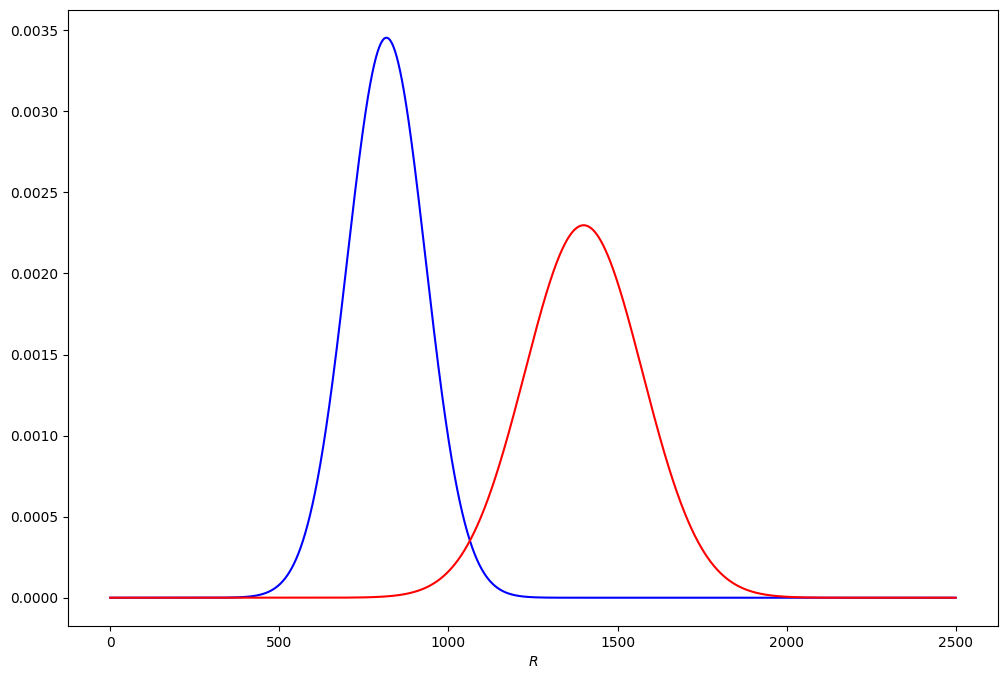

In [7]:
R_grid = np.linspace(0, 2500, 10000)

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xlabel(r'$R$')

ax.plot(R_grid, scipy.stats.norm.pdf(R_grid, loc=R1, scale=sigma_R1), color='blue', label=r'$R_1$')
ax.plot(R_grid, scipy.stats.norm.pdf(R_grid, loc=R2, scale=sigma_R2), color='red', label=r'$R_1$')

plt.show()

## What do I need to measure to conclude that $A = A_0$?

The equation for $\lambda_\text{LR}$ can be rewritten as:
$$\xi \alpha_0^{\dfrac{\alpha}{1 + \alpha}} - \alpha_0 - 1 = 0$$
with
$$\xi = \left[\exp\left(\dfrac{\lambda_\text{LR}}{2 N_2}\right) \left(1 + \dfrac{1}{\alpha}\right)^\alpha \left(1 + \alpha\right)\right]^\dfrac{1}{1 + \alpha}$$

When solving for $\alpha = \dfrac{N_1}{N_2}$, typically this has two roots: before and after $\alpha_0$.

When solving for $\alpha_0$, typically this has two roots: before and after $\alpha = \dfrac{N_1}{N_2}$

### Fix $a$, find $\alpha$

Let's say we know the value of $a$. What $A = \dfrac{R_1}{R_2}$ do I have to measure to conclude that $A = \alpha a = A_0$? This is equivalent to ask what $\alpha = \dfrac{N_1}{N_2}$ do I have to measure to conclude that $\alpha = \dfrac{N_1}{N_2} = \alpha_0 = \dfrac{A_0}{a}$. Fix the value of $A_0$ (e.g. $A_0 = 1$) and compute the $\alpha_0$ (given $a$).

For a fixed $\text{c.l.}$ we can retrieve the corresponding value of $\lambda_\text{LR}$ using the $\chi^2_1$ distribution. For example $\text{c.l.} = 0.05 \Longrightarrow \lambda_\text{LR} \simeq 3.841$.

Then we can solve the equation above for $\alpha$ as a function of $N_2$, and plot $\alpha$ vs. $N_2$.

In [8]:
# Retrieve the value of lambda_LR for the chosen confidence level
# The "isf" function is called the "inverse survival function". See above for the "sf" function.
lambda_LR_target = scipy.stats.chi2.isf(cl, 1)

# Fix the value of A_0
A_0_ref = 1
# A_0_ref = A
# A_0_ref = (N_1 / N_2) * a

# Compute the value of alpha_0 = A_0 / a
alpha_0_ref = A_0_ref / a

# Define a grid of values for N_2
n2_min, n2_max = 10, 100
N_2_grid = np.array(range(n2_min, n2_max + 1))

In [9]:
# Define the equation to solve for alpha (named x for clarity)
alpha_eq = lambda x, N_2, alpha_0_ref: ((np.exp(lambda_LR_target / (2 * N_2)) *\
                            (1 + 1 / x) ** x * (1 + x)) ** (1 / (1 + x))) * alpha_0_ref ** (x / (1 + x)) - alpha_0_ref - 1

In [10]:
# Use a root finding algorithm to solve the equation
# Typically this has two (positive) roots: before and after alpha_0.
alpha_target_sx = np.array([find_root(alpha_eq, (0.1, alpha_0_ref), args=(n_2, alpha_0_ref)).x for n_2 in N_2_grid])
alpha_target_dx = np.array([find_root(alpha_eq, (alpha_0_ref, 10), args=(n_2, alpha_0_ref)).x for n_2 in N_2_grid])

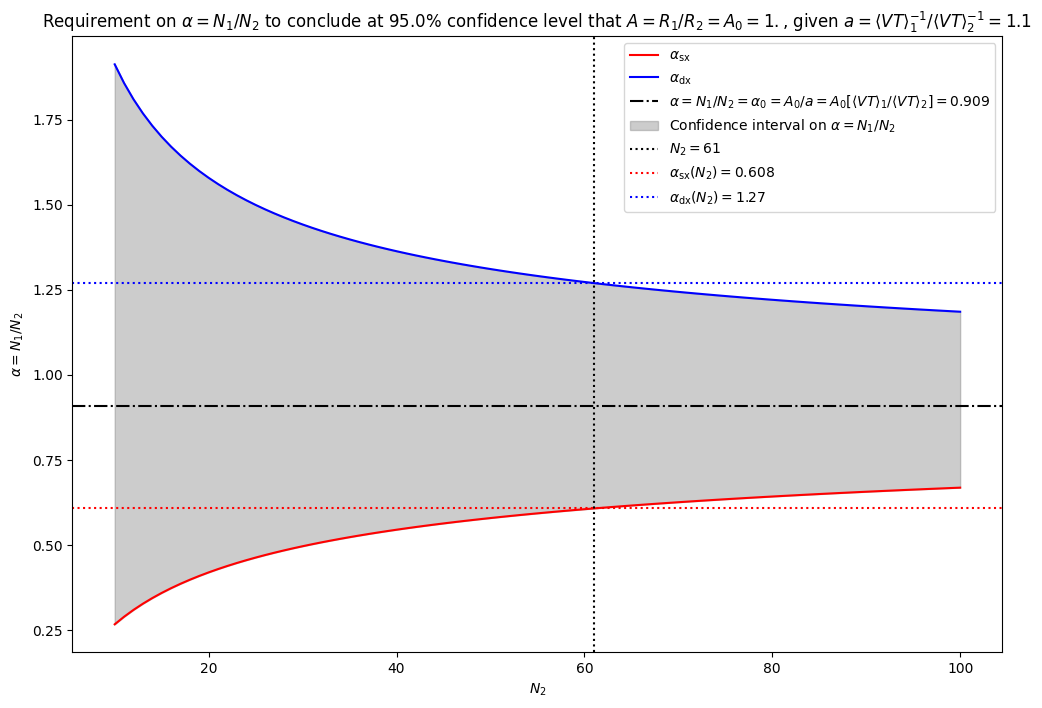

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'Requirement on $\alpha = N_1 / N_2$ to conclude at ${0}\%$ confidence level that $A = R_1 / R_2 = A_0 = {1}$, given $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}} = {2}$'.format((1 - cl) * 100, np.format_float_positional(A_0_ref, 3), a))

ax.set_xlabel(r'$N_2$')
ax.set_ylabel(r'$\alpha = N_1 / N_2$')

# alpha_target vs N_2
ax.plot(N_2_grid, alpha_target_sx, color='red', label=r'$\alpha_\text{sx}$')
ax.plot(N_2_grid, alpha_target_dx, color='blue', label=r'$\alpha_\text{dx}$')

# Central value of alpha_target for having A = A_0, at fixed a
ax.axhline(alpha_0_ref, linestyle='-.', color='black', label=r'$\alpha = N_1 / N_2 = \alpha_0 = A_0 / a = A_0 [\langle VT \rangle_1 / \langle VT \rangle_2] = {0}$'.format(np.format_float_positional(alpha_0_ref, 3)))

# Confidence interval
ax.fill_between(N_2_grid, alpha_target_sx, alpha_target_dx, color='gray', alpha=0.4, label=r'Confidence interval on $\alpha = N_1 / N_2$')

# Reference lines for the chosen N_2
ax.axvline(N_2, linestyle=':', color='black', label=r'$N_2 = {0}$'.format(N_2))
N_2_index = np.where(N_2_grid == N_2)[0][0]
ax.axhline(alpha_target_sx[N_2_index], linestyle=':', color='red', label=r'$\alpha_\text{{sx}}(N_2) = {0}$'.format(np.format_float_positional(alpha_target_sx[N_2_index], 3)))
ax.axhline(alpha_target_dx[N_2_index], linestyle=':', color='blue', label=r'$\alpha_\text{{dx}}(N_2) = {0}$'.format(np.format_float_positional(alpha_target_dx[N_2_index], 3)))

ax.legend()

plt.show()

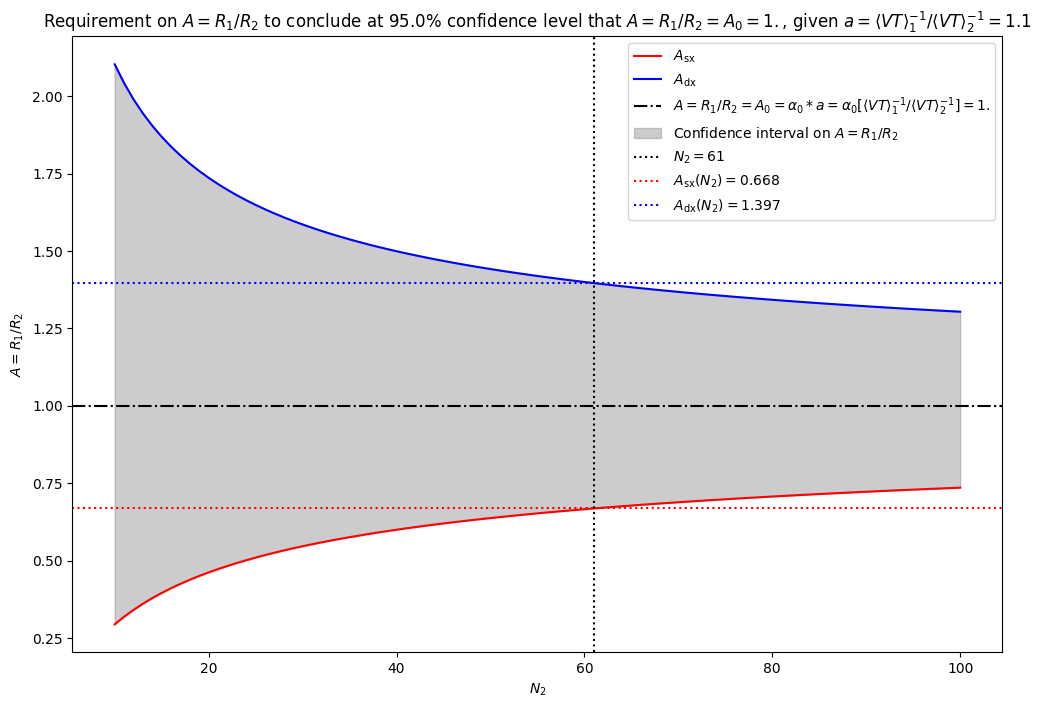

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'Requirement on $A = R_1 / R_2$ to conclude at ${0}\%$ confidence level that $A = R_1 / R_2 = A_0 = {1}$, given $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}} = {2}$'.format((1 - cl) * 100, np.format_float_positional(A_0_ref, 3), a))

ax.set_xlabel(r'$N_2$')
ax.set_ylabel(r'$A = R_1 / R_2$')

# alpha_target vs N_2
ax.plot(N_2_grid, alpha_target_sx * a, color='red', label=r'$A_\text{sx}$')
ax.plot(N_2_grid, alpha_target_dx * a, color='blue', label=r'$A_\text{dx}$')

# Central value of alpha_target for having A = A_0, at fixed a
ax.axhline(A_0_ref, linestyle='-.', color='black', label=r'$A = R_1 / R_2 = A_0 = \alpha_0 * a = \alpha_0 [\langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}}] = {0}$'.format(np.format_float_positional(A_0_ref, 3)))

# Confidence interval
ax.fill_between(N_2_grid, alpha_target_sx * a, alpha_target_dx * a, color='gray', alpha=0.4, label=r'Confidence interval on $A = R_1 / R_2$')

# Reference lines for the chosen N_2
ax.axvline(N_2, linestyle=':', color='black', label=r'$N_2 = {0}$'.format(N_2))
N_2_index = np.where(N_2_grid == N_2)[0][0]
ax.axhline(alpha_target_sx[N_2_index] * a, linestyle=':', color='red', label=r'$A_\text{{sx}}(N_2) = {0}$'.format(np.format_float_positional(alpha_target_sx[N_2_index] * a, 3)))
ax.axhline(alpha_target_dx[N_2_index] * a, linestyle=':', color='blue', label=r'$A_\text{{dx}}(N_2) = {0}$'.format(np.format_float_positional(alpha_target_dx[N_2_index] * a, 3)))

ax.legend()

plt.show()

### Fix $\alpha$, find $a$

Suppose now we know the value of $\alpha = \dfrac{N_1}{N_2}$. What $a = \dfrac{\langle VT \rangle_1^{-1}}{\langle VT \rangle_2^{-1}}$ do I need to conclude that $A = \dfrac{R_1}{R_2} = \dfrac{N_1}{N_2} \dfrac{\langle VT \rangle_1^{-1}}{\langle VT \rangle_2^{-1}} = \alpha a = A_0$? Equivalently: what $a = \dfrac{\langle VT \rangle_1^{-1}}{\langle VT \rangle_2^{-1}}$ do I need to conclude that $\alpha = \dfrac{N_1}{N_2} = \alpha_0 = \dfrac{A_0}{a} = A_0 \dfrac{\langle VT \rangle_1}{\langle VT \rangle_2}$?

Since now we know the value of $\alpha = \dfrac{N_1}{N_2}$, we can ask what value of $\alpha_0$ would I have to set to conclude that $\alpha = \dfrac{N_1}{N_2} = \alpha_0$. This implies solving the same equation above, but this time for $\alpha_0$ instead of $\alpha$.

Once we get the searched value of $\alpha_0$, we can retrieve $a = \dfrac{\langle VT \rangle_1^{-1}}{\langle VT \rangle_2^{-1}}$ simply using $a = \dfrac{A_0}{\alpha_0}$, where $A_0$ is fixed like before.

Then we can plot the found value of $a = \dfrac{\langle VT \rangle_1^{-1}}{\langle VT \rangle_2^{-1}}$ vs. $N_2$ used to solve the equation.

In [13]:
# Retrieve the value of lambda_LR for the chosen confidence level
# The "isf" function is called the "inverse survival function". See above for the "sf" function.
lambda_LR_target = scipy.stats.chi2.isf(cl, 1)

# Define a grid of values for N_2
n2_min, n2_max = 10, 100
N_2_grid = np.array(range(n2_min, n2_max + 1))

In [14]:
# Define the equation to solve for alpha_0 (named x for clarity)
alpha_0_eq_n2 = lambda x, N_2: (np.exp(lambda_LR_target / (2 * N_2)) *\
                             (1 + 1 / alpha) ** alpha * (1 + alpha)) ** (1 / (1 + alpha)) * x ** (alpha / (1 + alpha)) - x - 1

In [15]:
# Use a root finding algorithm to solve the equation
# Typically this has two (positive) roots: before and after alpha.
alpha_0_target_sx_n2 = np.array([find_root(alpha_0_eq_n2, (0.1, alpha), args=(n_2)).x for n_2 in N_2_grid])
alpha_0_target_dx_n2 = np.array([find_root(alpha_0_eq_n2, (alpha, 10), args=(n_2)).x for n_2 in N_2_grid])

# Compute the value of a = A_0 / alpha_0
a_target_sx_n2 = A_0_ref / alpha_0_target_sx_n2
a_target_dx_n2 = A_0_ref / alpha_0_target_dx_n2

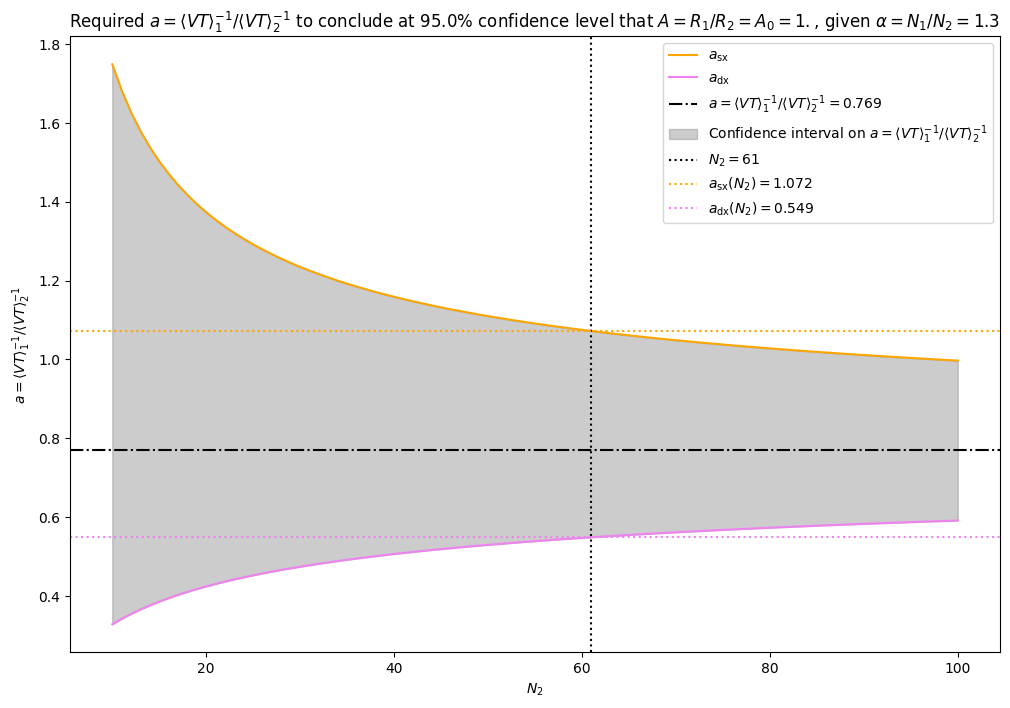

In [16]:
# PLOT
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'Required $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}}$ to conclude at ${0}\%$ confidence level that $A = R_1 / R_2 = A_0 = {1}$, given $\alpha = N_1 / N_2 = {2}$'.format((1 - cl) * 100, np.format_float_positional(A_0_ref, 3), alpha))

ax.set_xlabel(r'$N_2$')
ax.set_ylabel(r'$a = \langle VT \rangle_1^{-1} / \langle VT \rangle_2^{-1}$')

# a_target vs. N_2
ax.plot(N_2_grid, a_target_sx_n2, color='orange', label=r'$a_\text{sx}$')
ax.plot(N_2_grid, a_target_dx_n2, color='violet', label=r'$a_\text{dx}$')

# Central value of a_target for having A = A_0, at fixed alpha
ax.axhline(A_0_ref / alpha, linestyle='-.', color='black', label=r'$a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}} = {0}$'.format(np.format_float_positional(A_0_ref / alpha, 3)))

# Confidence interval
ax.fill_between(N_2_grid, a_target_sx_n2, a_target_dx_n2, color='gray', alpha=0.4, label=r'Confidence interval on $a = \langle VT \rangle_1^{-1} / \langle VT \rangle_2^{-1}$')

# Reference lines for the chosen N_2
ax.axvline(N_2, linestyle=':', color='black', label=r'$N_2 = {0}$'.format(N_2))
N_2_index = np.where(N_2_grid == N_2)[0][0]
ax.axhline(a_target_sx_n2[N_2_index], linestyle=':', color='orange', label=r'$a_\text{{sx}}(N_2) = {0}$'.format(np.format_float_positional(a_target_sx_n2[N_2_index], 3)))
ax.axhline(a_target_dx_n2[N_2_index], linestyle=':', color='violet', label=r'$a_\text{{dx}}(N_2) = {0}$'.format(np.format_float_positional(a_target_dx_n2[N_2_index], 3)))

ax.legend()

plt.show()

The same calculation can be done for a fixed value of $N_2$ and varying $\alpha = \dfrac{N_1}{N_2}$.

In [17]:
# Define a grid of values for alpha
alpha_grid = np.linspace(0.1, 7, 1000)

In [18]:
# Define the equation to solve for alpha_0 (named x for clarity)
alpha_0_eq_alpha = lambda x, alpha: (np.exp(lambda_LR_target / (2 * N_2)) *\
                                     (1 + 1 / alpha) ** alpha * (1 + alpha)) ** (1 / (1 + alpha)) * x ** (alpha / (1 + alpha)) - x - 1

In [19]:
# Use a root finding algorithm to solve the equation
# Typically this has two (positive) roots: before and after alpha.
alpha_0_target_sx_alpha = np.array([find_root(alpha_0_eq_alpha, (0.1, alpha), args=(alpha)).x for alpha in alpha_grid])
alpha_0_target_dx_alpha = np.array([find_root(alpha_0_eq_alpha, (alpha, 10), args=(alpha)).x for alpha in alpha_grid])

# Compute the value of a = A_0 / alpha_0
a_target_sx_alpha = A_0_ref / alpha_0_target_sx_alpha
a_target_dx_alpha = A_0_ref / alpha_0_target_dx_alpha

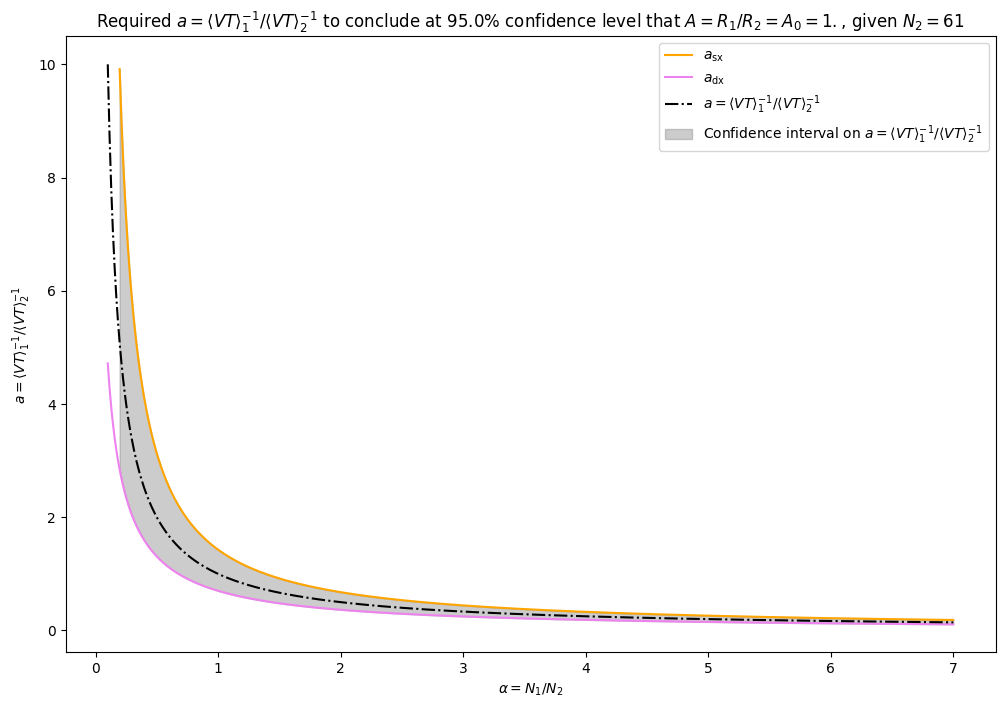

In [20]:
# PLOT
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'Required $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}}$ to conclude at ${0}\%$ confidence level that $A = R_1 / R_2 = A_0 = {1}$, given $N_2 = {2}$'.format((1 - cl) * 100, np.format_float_positional(A_0_ref, 3), N_2))

ax.set_xlabel(r'$\alpha = N_1 / N_2$')
ax.set_ylabel(r'$a = \langle VT \rangle_1^{-1} / \langle VT \rangle_2^{-1}$')

# a_target vs. N_2
ax.plot(alpha_grid, a_target_sx_alpha, color='orange', label=r'$a_\text{sx}$')
ax.plot(alpha_grid, a_target_dx_alpha, color='violet', label=r'$a_\text{dx}$')

# Central value of a_target for having A = A_0, at fixed alpha
ax.plot(alpha_grid, A_0_ref / alpha_grid, linestyle='-.', color='black', label=r'$a = \langle VT \rangle_1^{-1} / \langle VT \rangle_2^{-1}$')

# Confidence interval
ax.fill_between(alpha_grid, a_target_sx_alpha, a_target_dx_alpha, color='gray', alpha=0.4, label=r'Confidence interval on $a = \langle VT \rangle_1^{-1} / \langle VT \rangle_2^{-1}$')

ax.legend()

plt.show()

# Bayesian approach

Comparison of two bin containing $N_1$ and $N_2$ events. The number of events in each bin is poissonian distributed as $\mathrm{Pois}(N_1 | \lambda_1)$ and $\mathrm{Pois}(N_2 | \lambda_2)$.

Using the conjugate prior of the Poisson distribution (the [Gamma distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html)), the posterior on $\lambda$ is given by $p(\lambda | N) = \mathrm{Gamma}(\lambda | \alpha + N, \beta + 1)$. A possibile choice for the parameters of the prior distribution might be the (uninformative) [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior): $\alpha = 0.5$ and $\beta = 0$.

In [21]:
n_samples = 100000
# Jeffreys prior
alpha_prior = 0.5
beta_prior = 0

beta_posterior = beta_prior + 1

# Generate samples from the posterior distribution of lambda_1 and lambda_2
lambda_1 = scipy.stats.gamma.rvs(alpha_prior + N_1, scale=1 / beta_posterior, size=n_samples)
lambda_2 = scipy.stats.gamma.rvs(alpha_prior + N_2, scale=1 / beta_posterior, size=n_samples)

# Compute the ratio of the two samples
lambda_ratio = lambda_1 / lambda_2

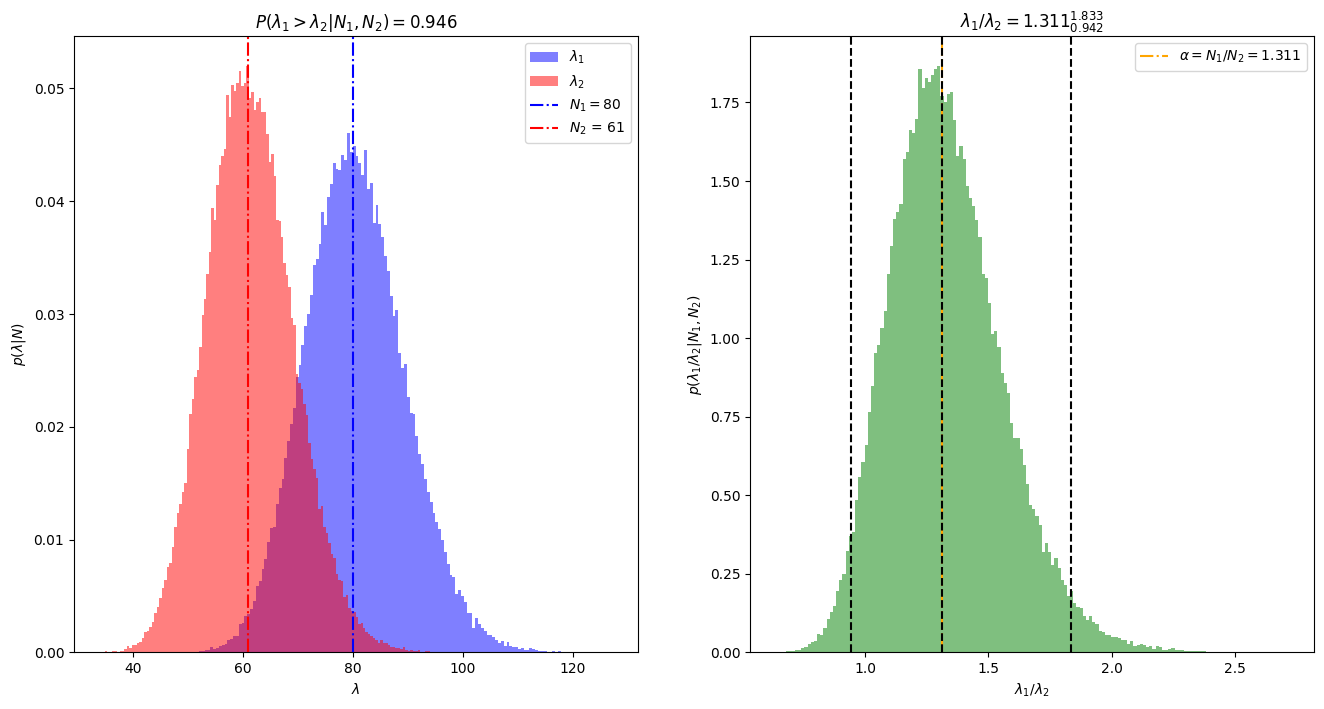

In [22]:
# PLOT
#---------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Posteriors of lambda_1 and lambda_2
#--------------------------------------------------
axes[0].set_title(r'$P(\lambda_1 > \lambda_2 | N_1, N_2) = {0}$'.format(np.format_float_positional(np.sum(lambda_1 > lambda_2) / n_samples, 3)))
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel(r'$p(\lambda | N)$')

# Posteriors
for sample, lb, c in zip([lambda_1, lambda_2], [r'$\lambda_1$', r'$\lambda_2$'], ['blue', 'red']):
    axes[0].hist(sample, bins='auto', density=True, alpha=0.5, color=c, label=lb)

for N, lb, c in zip([N_1, N_2], [r'$N_1 = {0}$', r'$N_2$ = {0}'], ['blue', 'red']):
    axes[0].axvline(N, linestyle='-.', color=c, label=lb.format(N))

# Posterior of lambda_1 / lambda_2
#--------------------------------------------------
# Quantiles
q = np.quantile(lambda_ratio, [0.025, 0.5, 0.975])

axes[1].set_title(r'$\lambda_1 / \lambda_2 = {1}_{{{0}}}^{{{2}}}$'.format(*[np.format_float_positional(_q, 3) for _q in q]))
axes[1].set_xlabel(r'$\lambda_1 / \lambda_2$')
axes[1].set_ylabel(r'$p(\lambda_1 / \lambda_2 | N_1, N_2)$')

# Posterior
axes[1].hist(lambda_ratio, bins='auto', density=True, alpha=0.5, color='green')
# True value of alpha
axes[1].axvline(N_1 / N_2, linestyle='-.', color='orange', label=r'$\alpha = N_1 / N_2 = {0}$'.format(np.format_float_positional(N_1 / N_2, 3)))
# Quantiles
for _q in q:
    axes[1].axvline(_q, linestyle='--', color='black')

#-----------------------------------------------------
for ax in axes:
    ax.legend()

plt.show()

The posterior on the rates is given by $R(\Delta m_i, \Delta z_j) = \dfrac{\lambda_{ij}}{\left\langle VT \right\rangle_{ij}}$, where $\lambda_{ij}$ are samples from the posterior of the bin.

The posterior on the rates ratio is given by $\dfrac{R_1}{R_2} = \dfrac{\lambda_1}{\lambda_2} a$, where $a = \dfrac{\dfrac{1}{\left\langle VT \right\rangle_1}}{\dfrac{1}{\left\langle VT \right\rangle_2}}$

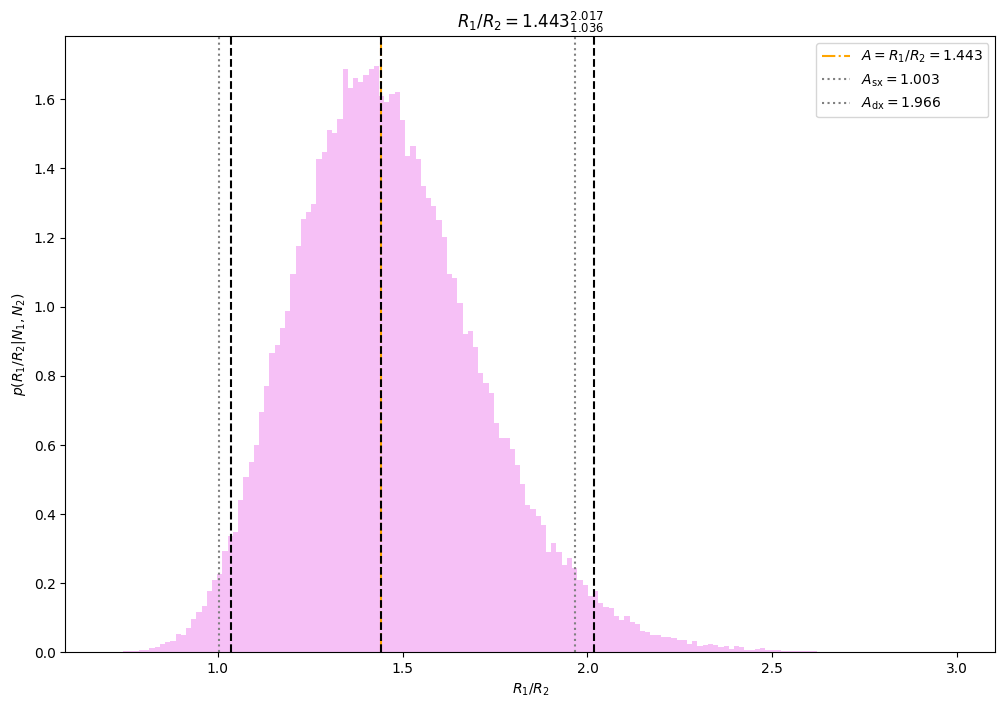

In [23]:
# Compute the rate ratio using the spacetime-volume ratio
rate_ratio = (lambda_1 / lambda_2) * a

# Quantiles
q = np.quantile(rate_ratio, [0.025, 0.5, 0.975])

# PLOT
#---------------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$R_1 / R_2 = {1}_{{{0}}}^{{{2}}}$'.format(*[np.format_float_positional(_q, 3) for _q in q]))
ax.set_xlabel(r'$R_1 / R_2$')
ax.set_ylabel(r'$p(R_1 / R_2 | N_1, N_2)$')

# Posterior
ax.hist(rate_ratio, bins='auto', density=True, alpha=0.5, color='violet')
# True value of A
ax.axvline((N_1 / N_2) * a, linestyle='-.', color='orange', label=r'$A = R_1 / R_2 = {0}$'.format(np.format_float_positional((N_1 / N_2) * a, 3)))
# Quantiles
for _q in q:
    ax.axvline(_q, linestyle='--', color='black')

#-----------------------------------------------------
# Confidence interval from the likelihood-ratio test
A_sx = find_root(alpha_eq, (0.1, N_1 / N_2), args=(N_2, N_1 / N_2)).x * a
A_dx = find_root(alpha_eq, (N_1 / N_2, 10), args=(N_2, N_1 / N_2)).x * a

for _A, lb in zip([A_sx, A_dx], [r'$A_\text{{sx}} = {0}$', r'$A_\text{{dx}} = {0}$']):
    ax.axvline(_A, linestyle=':', color='gray', label=lb.format(np.format_float_positional(_A, 3)))

ax.legend()

plt.show()